# Lecture 1: fundamentals

Noteboook by Mark Graham, adapted by Emma Robinson

## Exercise 2: Implementing a single neuron classifier through logistic regression

In this section we will train a classifier to predict if a neonate is preterm based on volume measures of 86 brain volumes. We will code up and train a logistic regression classifier from scratch.

### Import the data
The data are in the file "prem_vs_termwrois.pkl". The final column indicates whether each data set was collected from a term or preterm baby (scanned at term equivalent age). The data represent mean vales of three different types of cortical imaging data: cortical thickness, cortical folding and cortical myelination, all averaged within 100 regions of interest ROIS on the surface. This gives 300 features in total. 

<img src="imgs/cortical_rois.png" alt="Drawing" style="width: 800px;"/>

There are 101 babies, 50 terms and 51 preterms. The code below loads the file and splits the data randomly into a train and test set. The data is transposed such that the rows reflect features and the columns examples (as expected from the lectures notation). A row of ones is added to each dataset to allow modelling of the bias term.

Run the code, be sure to understand what each line is doing.

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# Read the data
df = pd.read_pickle("prem_vs_termwrois.pkl")
data = df.values[:,:-2]
y = df.values[:,-1]

# create a test and train split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=42)

# Create feature matrix
X_train = X_train.T
X_test=X_test.T
bias_row=np.ones((1,X_train.shape[1]))
print(X_train.shape,X_test.shape)

print(bias_row.shape)
X_train = np.concatenate((np.ones((1,X_train.shape[1])),X_train))
X_test = np.concatenate((np.ones((1,X_test.shape[1])),X_test))



# set variables for numbers of feature and examples to improve readabiity of code
n_features=X_train.shape[0]-1
n_examples=X_train.shape[1]

print('Dimension of X is ', X_train.shape,data.shape)
print('Dimension of y is ', y.shape)

print('Number of features', n_features)
print('Number of examples', n_examples)

(300, 90) (300, 11)
(1, 90)
Dimension of X is  (301, 90) (101, 300)
Dimension of y is  (101,)
Number of features 300
Number of examples 90


### Eyeball the data
The following code plots histograms of a single feature (brain volume) for preterms vs terms. Run the code for a few different values of 'feature'.

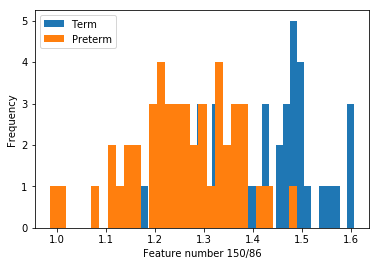

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

#### STUDENT'S CODE HERE ####
# try values between 0 and 300
feature = 150

plt.hist(X_train[feature+1, y_train==0], bins=30)
plt.hist(X_train[feature+1, y_train==1], bins=30)
plt.xlabel('Feature number {}/86'.format(feature))
plt.ylabel('Frequency')
plt.legend(['Term','Preterm']);

### Model

Our predictions for a single input can be written:
$$ f= f(z) = \dfrac{1}{1+e^{-z}} $$

Where, for logistic regression, $f$ is the sigmoid function and:

$$z=w_0 + w_1x_1 + w_2x_2 +w_3x_3....+w_m x_m$$

Here $w_0$ is the bias term, $w_1,w_2....w_m$ are the weights;, $m$ is the number of features and $\mathbf{x}$ is a single example from our training set $X \in \mathbb{R}^{m\times n}$ (of size $ m\times n$).


### Implementation of the forward pass

We could calculate $f$ in one line of code, but it will come in handy when considering backpropagation later to consider the computation in stages, with each stage consisting of a simple module:

$$
\begin{align} 
\mathbf{Z} &= \mathbf{W} \mathbf{X} \\
\mathbf{F}=f(\mathbf{Z}) &= \dfrac{1}{1+e^{-\mathbf{Z}}} 
\end{align}
$$

Implemented using vectorisation. 

### Task 2.1 Estimate $\mathbf{Z}$: 

Write a function $z(w,x)$ that uses vectorisation to linearly transform data matrix $\mathbf{X}$ using the weights matrix $\mathbf{W}$.

**Hint** $\mathbf{X}$ has size $m_{features} \times n_{examples}$. What size should the output matrix $\mathbf{Z}$ be?


In [33]:
def z(w,x):
    #### STUDENT'S CODE HERE ####
    return np.matmul(w, x)

Create an matrix of zeros to initialise $\mathbf{W}$. Verify your function $z(w,x)$ gives an output of the expected dimension.

- What dimension should $\mathbf{W}$ be? 
- What dimension should the product $\mathbf{W}^T\mathbf{X}$ be? 

In [34]:
#### STUDENT'S CODE HERE ####
# Answer:
w = np.zeros((1,X_train.shape[0]))
output = z(w,X_train)
print(output.shape)

(1, 90)


### Task 2.2 Implement Sigmoid function f: 

Now write a function to compute $f(\mathbf{Z})$, our logistic regression function:

In [35]:
def f(z):
    return 1 / (1+ np.exp(-z))

Verify your softmax looks right by running this plotting code:

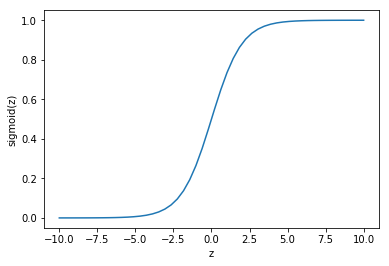

In [36]:
inputs = np.linspace(-10,10)
outputs = f(inputs)
plt.plot(inputs, outputs)
plt.xlabel('z')
plt.ylabel('sigmoid(z)');

We're now in a position to compute some predictions $\mathbf{\hat{y}}$:

In [37]:
y_pred = f(z(w,X_train))

Are these predictions any good? Let's take a look at the accuracy:

In [38]:
def accuracy(y, y_pred, threshold = 0.5):
    y_pred_thresholded = y_pred > threshold
    correct_predictions = np.sum(y==y_pred_thresholded)  
    total_predictions = np.shape(y)
    accuracy = 100 * correct_predictions / total_predictions
    return accuracy

In [39]:
y_pred = f(z(w, X_train))
print(accuracy(y_train, y_pred))

[47.77777778]


Look at the predictions ```y_pred```, what does this initial prediction return and why? Enter your answer in the box below

It returns 0.5 because weights are all zero

### Task 2.3 Implement Cross Entropy Loss:

Accuracy is easy to intepret, but can't be optimised using gradient descent. We need a measure of our prediction quality that can be. A typical loss function used in  classification problems is cross-entropy:

$$L(y_i,f(z_i)) = - y_i \ln(f(z_i)) - (1-y_i) \ln(1-f(z_i))$$

This may be implemented using vectorisation as:

$$L(\mathbf{Y},\mathbf{F}) = - \mathbf{Y} \ln(\mathbf{F}) - (1-\mathbf{Y}) \ln(1-\mathbf{F})$$

This returns a vector of losses $(L_1,L_2....L_n)$ estimated for all training examples n. We require the total cost estimated as:

$$ J(\mathbf{W})= \frac{1}{n} \sum_i L_i(y_i,f(z_i)) $$

Implement the Cross-Entropy loss and return the total cost (**hint** using numpy functions for vectorisation). 

In [40]:
def loss(y, y_pred):
    epsilon = 1e-5
    # note the negative sign so that the loss decreases as our predictions get better
    # we must add a small penaty term to prevent calculation of log(0)
    L = - y * np.log(y_pred+epsilon) - (1-y) * np.log(1-y_pred+epsilon) 
    J = np.mean(L)
    return J

In [41]:
total_loss= loss(y_train,y_pred)
print(total_loss)

0.6931271807599427


### Task 2.4 Implement Forward Pass


We now have all the components of the forward pass for our logistic regression. Write a full forward pass that takes data, targets and a weight matrix and performs the forward pass to calculate the loss:

**hint - One line** You have already defined all the vectorised functions you need above

In [42]:
def forward_pass(X, y, w):
    F = f(z(w,X))
    print('Loss: {}'.format(loss(y,F)))
    print('Accuracy: {}'.format(accuracy(y,F)))

In [43]:
#perform forward pass
forward_pass(X_train,y_train, w)

Loss: 0.6931271807599427
Accuracy: [47.77777778]


### Task 2.5 Implement backwards pass

We're now ready to try and adjust our parameters $\mathbf{W}$ in order to optimise our predictions. To do this we need to calculate the change in our loss function with respect to our parameters, $\dfrac{\partial L}{\partial \mathbf{W}}$. 

Recalling our staged calculation of the logistic regression (in vectorised form):

$$
\mathbf{Z} = \mathbf{W} \mathbf{X} \\
\mathbf{F}= \dfrac{1}{1+e^{- \mathbf{Z}}} \\
\mathbf{L}  =  - \mathbf{Y} \ln(\mathbf{F}) - (1-\mathbf{Y}) \ln(1-\mathbf{F})
$$

We can write the vectorised gradients for each individual stage (see lecture slides): 

$$
\dfrac{\partial L}{\partial f} = \dfrac{\mathbf{F} - \mathbf{Y}}{\mathbf{F}(1-\mathbf{F})}\\
\dfrac{\partial f}{\partial z} = \mathbf{F}(1-\mathbf{F}) \\
\dfrac{\partial z}{\partial w} = \mathbf{X}^T
$$

And compose through the chain rule:

$$ 
\dfrac{\partial L}{\partial w} = \dfrac{\partial L}{\partial f} \cdot \dfrac{\partial f}{\partial z} \cdot\dfrac{\partial z}{\partial w} \\
\dfrac{\partial L}{\partial w} = \dfrac{\mathbf{F} - \mathbf{Y}}{\mathbf{F}(1-\mathbf{F})} \cdot \mathbf{F}(1-\mathbf{F}) \cdot \mathbf{X}^T
$$

Which can be simplified by cancelling $ \mathbf{F}(1-\mathbf{F})$ terms in both the numerator and the denominator: 

$$ \dfrac{\partial L}{\partial w} = (\mathbf{F} - \mathbf{Y}) \mathbf{X}^T $$

Let's calculate the gradient of our loss, $\dfrac{\partial L}{\partial \mathbf{W}}$, for a **single** input, $\mathbf{x}$. Fill in the calculations of the backward pass in the following code:

In [44]:
w = np.zeros((1,X_train.shape[0]))

# select just the first example here
x = X_train[:,0]
y_single = y[0]
print('The true value of y is: {}'.format(y_single))

# calculate the forward pass, and store the outputs at each stage
Z = z(w,x)
F = f(Z)
print('Our prediction for y is: {}'.format(F))

l = loss(y_single,F)
print('The loss is {}'.format(l))

# now enter the backwards pass here, 
#implementing using the equations above:
dl_dw = (F-y_single)*x.T

print(dl_dw.shape,w.shape,x.shape)

The true value of y is: 0.0
Our prediction for y is: [0.5]
The loss is 0.6931271807599427
(301,) (1, 301) (301,)


We can check this gradient calculation is correct by updating our weights vector and looking at our new prediction:

In [45]:
# The gradient is in the direction of increasing loss,
# so we subtract the gradient from w.
w = w - 0.001 * dl_dw
Z = z(w,x)
F = f(Z)
l = loss(y_single,F)
print('Our updated prediction for y is: {}'.format(F))
print('The loss is {}'.format(l))

Our updated prediction for y is: [0.46391763]
The loss is 0.62344880146802


Looks good! We have only updated $\mathbf{w}$ using information from a single data point. In practice we want to use all the data available. 

**To do** 
1. Perform the backward pass again, but this time with vectorisation. Check that the shape of `dL_dw` is what you would expect.
2. Estimate the full cost over all training examples

In [46]:
w = np.zeros((1,X_train.shape[0]))

# calculate the forward pass, and store the outputs at each stage
Z = z(w,X_train)
F = f(Z)
l = loss(y_train, F)

# To do - implement the backward pass
dL_dw = np.matmul((F-y_train),X_train.T) 

print('dL_dw has shape: {}'.format(dL_dw.shape))

grad_mean = dL_dw/n_examples

dL_dw has shape: (1, 301)


###  Putting it all together: the training loop

We now have everything we need to train a logistic regression classifier using backprop. Fill out the training loop below using the code you have already written in this notebook.

In [47]:
# initialise w to all zeros
w = np.zeros((1,X_train.shape[0]))
epsilon=1e-5
# centre X
X_centred = np.ones_like(X_train)
X_centred[1:] = (X_train[1:] -X_train[1:].mean(axis=1,keepdims=True)) / (X_train[1:].std(axis=1,keepdims=True)+epsilon)

# we'll store the loss and accuracy in these lists during training
loss_record = []
accuracy_record = []

num_iterations = 2000
learning_rate = 1e-3

for i in range(num_iterations):
    # forward pass - get predictions
    #### STUDENT CODE HERE####
    # answer
    Z = z(w,X_centred)
    F = f(Z)
    l = loss(y_train,F)
    
    # store the loss/ accuracy at this iteration
    accuracy_it=accuracy(y_train,F)
    loss_record.append(l)
    accuracy_record.append(accuracy_it)
    
    #backwards pass to get gradients
    #### STUDENT CODE HERE #### 
    # answer:
    dL_dw = np.matmul((F-y_train),X_centred.T) 

    grad_mean = dL_dw/n_examples
    
    # update the 
    w = w - learning_rate * grad_mean

100.0


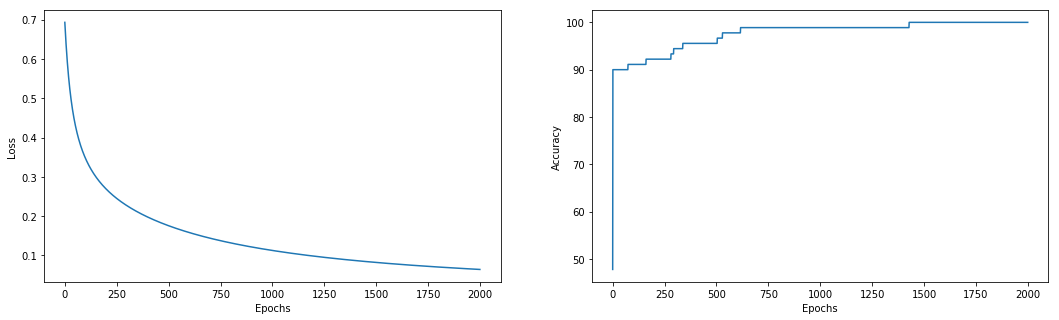

In [48]:
fig, ax = plt.subplots(1,2, figsize = (18,5))
ax[0].plot(loss_record)
ax[1].plot(accuracy_record)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy');

print(np.max(accuracy_record))

###  Now Testing on left out set

**task** test the performance of your logistic regression on your left out test set

In [49]:
# centre X
X_test_centred = np.ones_like(X_test)
X_test_centred[1:] = (X_test[1:] -X_test[1:].mean(axis=1,keepdims=True)) / (X_test[1:].std(axis=1,keepdims=True)+epsilon)

Z_test = z(w,X_test_centred)
F_test = f(Z_test)
l = loss(y_test,F_test)

print(l,accuracy(y_test,F_test))

0.17531616077619297 [90.90909091]


## The multi-layer perceptron (MLP)

A MLP for binary classification, containing a single hidden layer can be written:

$$ \hat{y} = f_2 \left( \mathbf{W_2} f_1 \left(\mathbf{W_1}\mathbf{X}\right) \right) $$

where $f_2$ is a non-linear activation function for the hidden layer (we use ReLu), 

$$ \text{Relu}(x) = \text{max}(0,x)$$

$f_1$ is  a non-linear activation function for the output layer (we use sigmoid for classification).  Note weight matrices t $\mathbf{W_1}$ and $\mathbf{W_2}$. 

In this toy example we will create a network with one hidden layer with 5 units. 

<img src="imgs/2layer.png" alt="Drawing" style="width: 500px;"/>

**Question** Given the shape of our input data, and the fact that we are still seeking the solution to a binary classification what are the number of input and output units for this problem (answer below)? 


**Answer here**: There are 301 output units and 1 output unit

We now go about implementing our simple network from scratch with gradient descent based optimisation

### The forward pass

Once again, we can write the forward pass as a staged computation:

$$
\mathbf{Z}_1 = \mathbf{W}_1 \mathbf{X} \\
\mathbf{F}_1 = \text{max}(0,\mathbf{Z_1}) \\
\mathbf{Z}_2 = \mathbf{W}_2 \mathbf{F}_1 \\
\mathbf{F}_2 = \dfrac{1}{1+e^{- \mathbf{Z_2}}} \\
\mathbf{L}  =  - \mathbf{Y} \ln(\mathbf{F_2}) - (1-\mathbf{Y}) \ln(1-\mathbf{F_2})
$$

Let's implement the forward pass. 

### Task 3.1 - First write code for the ReLU:

In [50]:
def relu(x):
    # Answer
    return x * (x>=0)

### Task 3.2 Implement a forward pass of the MLP below: 

Remember $\mathbf{W_1}$ and $\mathbf{W_2}$ must now be initialised as with small random numbers. What dimension must  $\mathbf{W_1}$ and $\mathbf{W_2}$ be?

In [56]:
#### STUDENTS CODE HERE ####
# Answer
W1 = np.random.randn(5,X_train.shape[0])
W2 = np.random.randn(1,5)
Z1 = np.matmul(W1,X_centred)
F1 = relu(Z1)
Z2 = np.matmul(W2,F1)
F2 = f(Z2) # recall f is the sigmoid function
l = loss(y_train,F2) 


### The backwards pass

The vectorised gradients of our MLP computation graph are, in reverse order, as follows:

$$\frac{\delta L}{\delta \mathbf{F}_2}=\frac{\mathbf{F}_2-\mathbf{Y}}{\mathbf{F}_2(1-\mathbf{F}_2)} \\
\frac{\delta  \mathbf{F}_2}{\delta  \mathbf{Z}_2}=\mathbf{F}_2(1-\mathbf{F}_2) \\
\frac{\delta  \mathbf{Z}_2}{\delta  \mathbf{W}_2}=\mathbf{F_1} \\
\frac{\delta  \mathbf{Z}_2}{\delta  \mathbf{F}_1}=\mathbf{W_2^T}\\
\frac{\delta  \mathbf{F}_1}{\delta  \mathbf{Z}_1}=1(\mathbf{Z}_1 >0)\\
\frac{\delta  \mathbf{Z}_1}{\delta  \mathbf{W}_1}=\mathbf{X}\\ $$


Combining these together using the chain rule we get (from lecture)

<img src="imgs/MLPbackprop.png" alt="Drawing" style="width: 700px;"/>

**Task** implement the missing parts of the vectorised backward pass, and copy in the forward pass from above.

**Hint** carefully consider the order in which the stages are combined (covered in the lecture). Check the dimensions of the outputs are as expected

**Note** 

`dL_dF1`=$$ \frac{\delta  L}{\delta  \mathbf{Z}_1}= \frac{\delta L}{\delta \mathbf{F}_2} \frac{\delta  \mathbf{F}_2}{\delta  \mathbf{Z}_2} \frac{\delta  \mathbf{Z}_2}{\delta  \mathbf{F}_1}   = W_2^T (\mathbf{F}_2-\mathbf{Y}) $$

`dL_dZ1`=$$ \frac{\delta  L}{\delta  \mathbf{Z}_1}= \frac{\delta L}{\delta \mathbf{F}_2} \frac{\delta  \mathbf{F}_2}{\delta  \mathbf{Z}_2} \frac{\delta  \mathbf{Z}_2}{\delta  \mathbf{F}_1} \frac{\delta  \mathbf{F}_1}{\delta  \mathbf{Z}_1}   =  \frac{\delta  L}{\delta  \mathbf{F}_1} \frac{\delta  \mathbf{F}_1}{\delta  \mathbf{Z}_1}  =   W_2^T (\mathbf{F}_2-\mathbf{Y}) * 1 (\mathbf{Z}_1 >0) $$

[96.66666667]


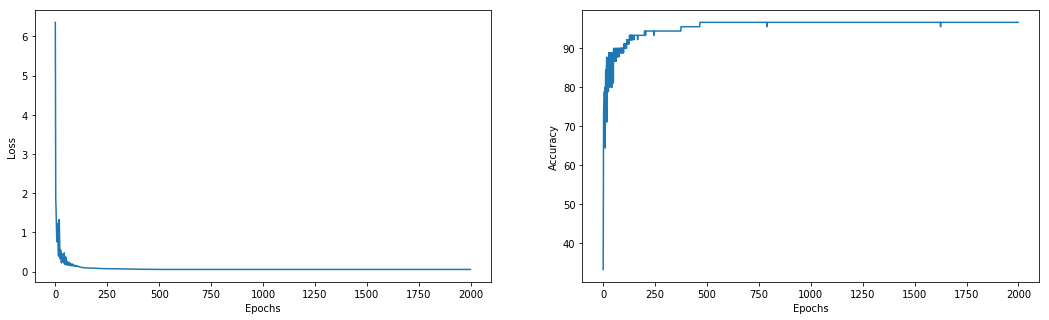

In [52]:
epsilon = 1e-5

# centre X
X_centred = np.ones_like(X_train)
X_centred[1:] = (X_train[1:] -X_train[1:].mean(axis=1,keepdims=True)) / (X_train[1:].std(axis=1,keepdims=True)+epsilon)

# initialise w1, w2
W1 = np.random.randn(5,X_train.shape[0])
W2 = np.random.randn(1,5)

# we'll store the loss and accuracy in these lists during training
loss_record_mlp = []
accuracy_record_mlp = []

num_iterations = 2000
learning_rate = 1e-2


for i in range(num_iterations):
    # forward pass - get predictions
    
    #### STUDENT CODE HERE####
    # please keep the output names of each stage so they work later with backprop
    Z1 = np.matmul(W1,X_centred)
    F1 = relu(Z1)
    Z2 = np.matmul(W2,F1)
    F2 = f(Z2) # recall f is the sigmoid function
    l = loss(y_train,F2) 

    # store the loss/ accuracy at this iteration
    loss_record_mlp.append(l)
    accuracy_record_mlp.append(accuracy(y_train,F2))

    
    #backwards pass to get gradients
    dL_dW2=np.matmul(F2-y_train,F1.T) 
    dL_dF1=np.matmul(W2.T,F2-y_train)      
    dF2_dZ1  = 1.0 *(Z1> 0)
    
    
    dL_dZ1=np.multiply(dL_dF1,dF2_dZ1)
    dL_dW1 = np.matmul(dL_dZ1,X_centred.T)
    dJ_dW2=(1/W2.shape[0])*dL_dW2 
    dJ_dW1=(1/W1.shape[0])*dL_dW1 

    # update the weights
    W2 = W2 - learning_rate * dJ_dW2    
    W1 = W1 - learning_rate * dJ_dW1
    
# plot loss and accuracy    
fig, ax = plt.subplots(1,2, figsize = (18,5))
ax[0].plot(loss_record_mlp)
ax[1].plot(accuracy_record_mlp)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy');

print(accuracy(y_train,F2))

### Testing the performance of the MLP

**Task** test the performance of your logistic regression on your left out test set

In [53]:
Z1_test = np.matmul(W1,X_test_centred)
F1_test = relu(Z1_test)
Z2_test = np.matmul(W2,F1_test)
F2_test = f(Z2_test) 
l = loss(y_test,F2_test) 

print(l,accuracy(y_test,F2_test))

0.2852162213459522 [90.90909091]


## Homework

1. Using multiclass data from sklearn iros data set implement a softmax multi-class classifier as 
    a) a single neuron
    b) an MLP
2. Try using a tanh or leaky relu in place of the relu function in the MLP classifier